In [13]:
import pandas as pd

# Cargar los archivos CSV
df1 = pd.read_csv('layoutsWithTags.csv')
df2 = pd.read_csv('layout_mas.csv', encoding='latin1')


# Fusionar los DataFrames en base a la columna layout_id
merged_df = pd.merge(df1, df2, on='layout_id')


In [15]:
merged_df.to_csv('layouts_todo2.csv', index=False)


In [16]:
print(merged_df.head())

   trial_id  layout_id country_x relevant (new) tags  coincidencia  \
0    9446.0      53750    Brazil           2,4,5,6,8          True   
1    9479.0      53772    Brazil          2,4,5,6,11          True   
2    9692.0      53808       USA                 NaN          True   
3    9692.0      53808       USA            1,3,4,10          True   
4    9672.0      53817       USA                 NaN          True   

              field_name              location country_y  latitude  longitude  \
0              LRV_Milho  State of Mato Grosso    Brasil   -12.680    -56.921   
1   Sertanopolis - Milho       State of Paraná    Brasil   -23.058    -51.039   
2                 CF2225                  Iowa       USA    41.878    -93.097   
3                 CF2225                  Iowa       USA    41.878    -93.097   
4  CF2223_B1_10ft_Normal                  Iowa       USA    41.878    -93.097   

       flight_date  
0  2/24/2022 15:32  
1   4/7/2022 16:11  
2  6/28/2022 13:55  
3  6/28/

In [19]:
import os
from PIL import Image, ImageStat
import pandas as pd

# Leer el archivo layouts_todo
layouts_todo = pd.read_csv('layouts_todo2.csv')  
directorio = './images'

filas = []

for index, row in layouts_todo.iterrows():
    layout_id = row['layout_id']
    country = row['country_x']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    # Filtro las fotos de ese layout
    imagenes_layout = [filename for filename in os.listdir(directorio) if filename.startswith(str(layout_id) + '_')]
    # Iterar por todas las fotos
    for filename in imagenes_layout:
        # Extraigo características
        img = Image.open(os.path.join(directorio, filename))
        ancho, alto = img.size
        brillo = img.getextrema()[0][0]
        tonalidad = img.getextrema()[1][0]

        # Saturación
        s, _, _ = img.convert('HSV').split()
        estadisticas_saturacion = ImageStat.Stat(s)
        saturacion = estadisticas_saturacion.mean[0]

        # Obtener datos de layouts_todo
        layout_info = layouts_todo[layouts_todo['layout_id'] == layout_id].iloc[0]  # Obtener la primera fila coincidente
        field_name = layout_info['field_name']
        location = layout_info['location']
        latitude = layout_info['latitude']
        longitude = layout_info['longitude']
        flight_date = layout_info['flight_date']

        # Agregar datos
        filas.append({
            'trial_id': row['trial_id'],
            'layout_id': layout_id,
            'country': country,
            'relevant (new) tags': relevant,
            'coincidencia': coincidencia,
            'nombre_imagen': filename,
            'ancho': ancho,
            'alto': alto,
            'brillo': brillo,
            'tonalidad': tonalidad,
            'saturacion': saturacion,
            'field_name': field_name,
            'location': location,
            'latitude': latitude,
            'longitude': longitude,
            'flight_date': flight_date
        })

# Convertir la lista de diccionarios en un DataFrame
nuevo_df2 = pd.DataFrame(filas)


In [21]:
import pandas as pd

# Supongamos que `nuevo_df2` ya está cargado con los datos del DataFrame

# Convertir la columna 'flight_date' a tipo datetime
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])

# Crear una nueva columna para el año
nuevo_df2['year'] = nuevo_df2['flight_date'].dt.year

# Crear una nueva columna para el mes
nuevo_df2['month'] = nuevo_df2['flight_date'].dt.month

# Obtener la lista de países únicos en el dataset
paises_unicos = nuevo_df2['country'].unique()

# Crear una tabla para almacenar el número de vuelos por mes y año para cada país
tabla_vuelos = pd.DataFrame()

# Iterar sobre cada país
for pais in paises_unicos:
    # Filtrar el DataFrame por país
    df_pais = nuevo_df2[nuevo_df2['country'] == pais]

    # Agrupar por año y mes y contar el número de vuelos
    vuelos_por_mes = df_pais.groupby(['year', 'month']).size().reset_index(name='count')

    # Agregar una columna para el país
    vuelos_por_mes['country'] = pais

    # Concatenar los resultados a la tabla general
    tabla_vuelos = pd.concat([tabla_vuelos, vuelos_por_mes])

# Reordenar las columnas de la tabla
tabla_vuelos = tabla_vuelos[['country', 'year', 'month', 'count']]

# Mostrar la tabla
print(tabla_vuelos)


     country  year  month  count
0     Brazil  2018     10    220
1     Brazil  2018     11    160
2     Brazil  2018     12     60
3     Brazil  2019      1     20
4     Brazil  2019      2    140
5     Brazil  2019      3    160
6     Brazil  2021      4     20
7     Brazil  2022      2     20
8     Brazil  2022      4     20
0        USA  2021      5    100
1        USA  2021      6     40
2        USA  2022      6    680
3        USA  2022      7     40
0  Argentina  2018     11    120
1  Argentina  2019      1     40
2  Argentina  2021      1    160
3  Argentina  2021      2    260


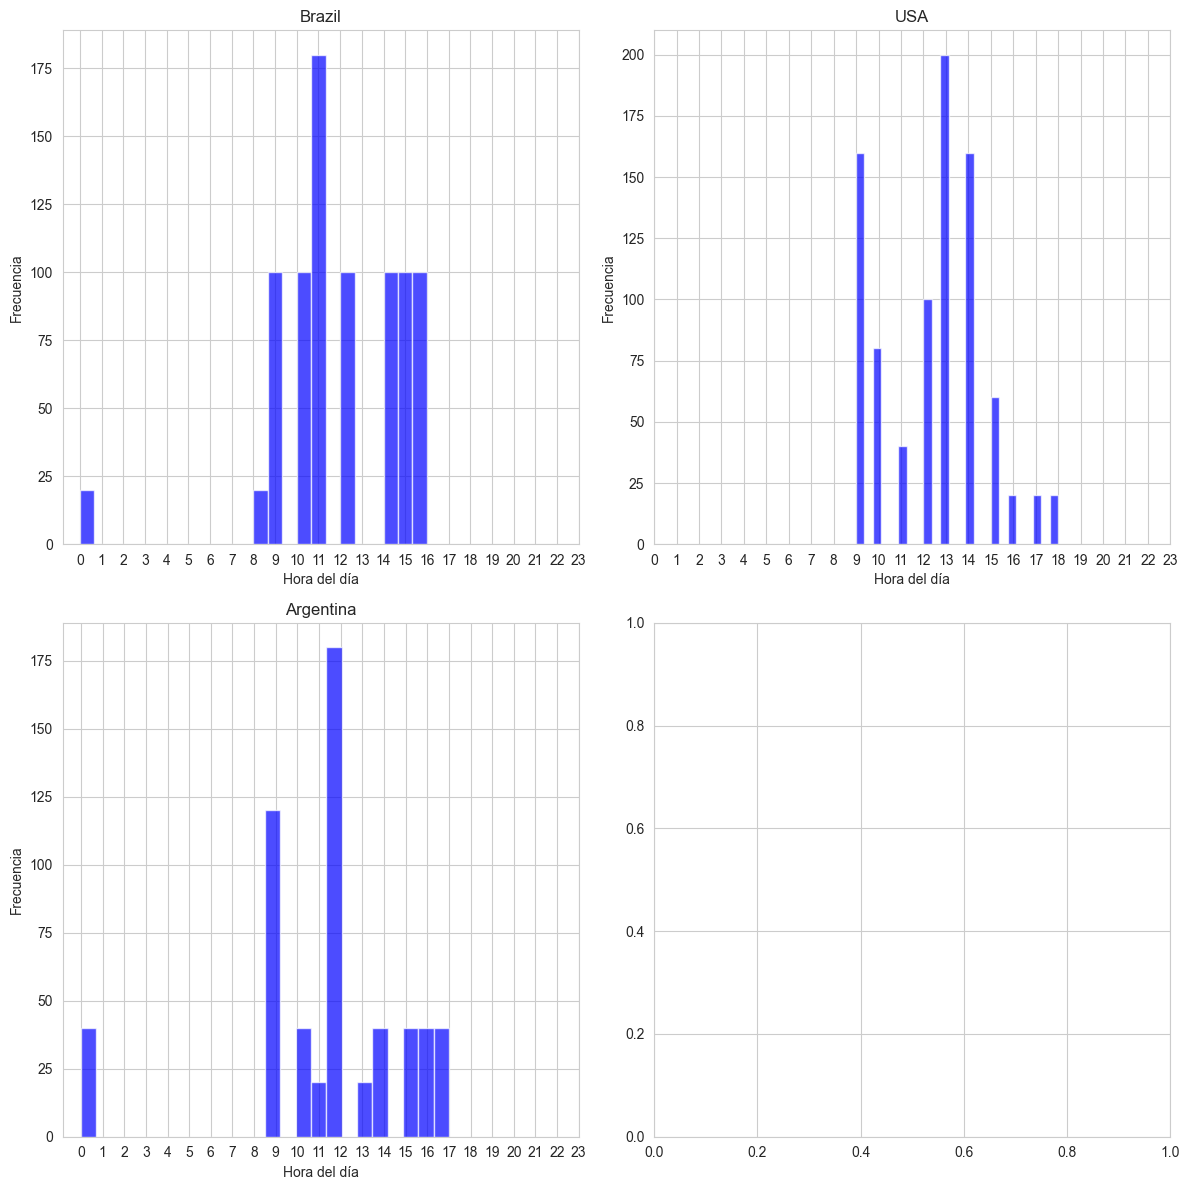

In [25]:
import matplotlib.pyplot as plt

# Obtener la lista de países únicos
paises = nuevo_df2['country'].unique()

# Configurar la disposición de los subplots
num_filas = (len(paises) + 1) // 2
num_columnas = 2
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 6*num_filas))

# Crear los histogramas para cada país
for i, pais in enumerate(paises):
    # Filtrar los datos por país
    data_pais = nuevo_df2[nuevo_df2['country'] == pais]
    
    # Obtener la frecuencia de vuelos por hora
    frecuencia_horarios = data_pais['flight_date'].dt.hour
    
    # Configurar los subplots
    ax = axs[i // num_columnas, i % num_columnas]
    
    # Crear el histograma
    ax.hist(frecuencia_horarios, bins=24, alpha=0.7, color='blue')
    ax.set_title(pais)
    ax.set_xlabel('Hora del día')
    ax.set_ylabel('Frecuencia')
    ax.set_xticks(range(24))
    ax.grid(True)
    
# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los histogramas
plt.show()



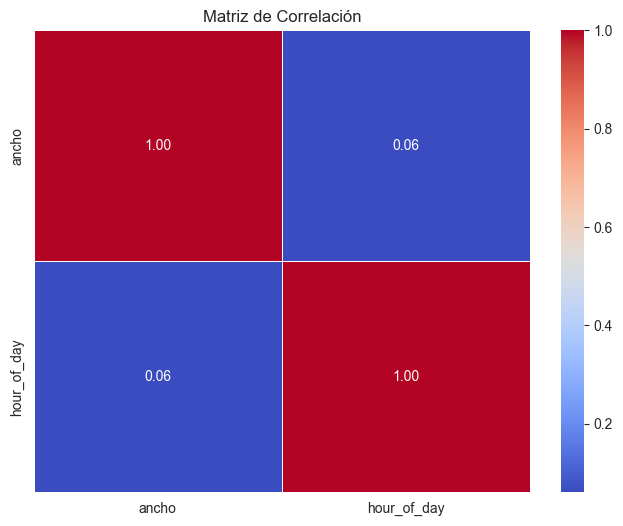

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extraer la hora del día de la columna de fecha
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['hour_of_day'] = nuevo_df2['flight_date'].dt.hour

# 2. Agrupar los datos por hora del día y calcular estadísticas resumidas del ancho de la foto
grupo_por_hora = nuevo_df2.groupby('hour_of_day')['ancho'].describe()

# 3. Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(grupo_por_hora.index, grupo_por_hora['mean'], marker='o', linestyle='-')
plt.fill_between(grupo_por_hora.index, grupo_por_hora['mean'] - grupo_por_hora['std'], grupo_por_hora['mean'] + grupo_por_hora['std'], alpha=0.3)
plt.title('Ancho de la Foto por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Ancho de la Foto (px)')
plt.xticks(range(24))
plt.grid(True)
plt.show()
